# ***Advanced Methods in Medical Signals and Images: Semantic Segmentation using U-Net architecture***

Welcome to the last assignment of the subject *Advanced Methods in Medical Signals and Images: Semantic Segmentation using U-Net architecture* (TSIM) from the MSc in Biomedical Engineering, Universidad Politécnica de Madrid (MUIB-UPM).

In this assignment, you will learn how to implement a deep learning-based workflow for medical image segmentation of different anatomical structures present in chest X-rays. You will learn how to implement a well known and efficient architecture called **U-Net** (see original paper [here]("https://arxiv.org/abs/1505.04597")).

To get started, please follow the next steps (also included in the document attached to the assignment):

1. Sign in with your Google account (upper left button)
2. Click in *File/Save a copy in Drive*. By default, your notebook will be stored at `MyDrive/Colab Notebooks`.
3. Inside this directory, create a new folder called `TSIM_UNet`, and move the notebook inside this directory.
4. Change the name of the notebook by right-clicking in the name of the file, and clicking on *Rename* with the format `UNet_surname1_surname2.ipynb`. Rename the file with the last names of each team member where indicated.
5. Create another folder next to the Notebook (`.ipynb`) called `data`. Once this is done, we should have something like this:

> 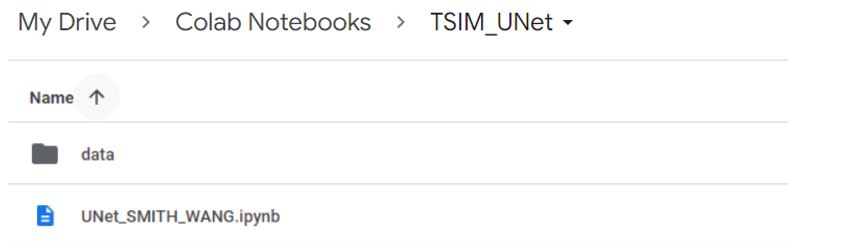

5. Next, upload the `TSIM_UNet_data.mat` file to the `data` folder.
6. Open your notebook and click on *Connect* (upper left corner)
7. Now you can start editing the notebook! The modified notebook will be saved in your Drive account. When you are finished, click on *File/Download .ipynb* to export the file and upload it to Moodle.

Double click here to edit your name and surname

**NAME AND SURNAME:** Vic Bracke

**NAME AND SURNAME:** Luna Demedts

# Table of Contents
You can also browse the contents of this notebook using the left side panel.

* [1 - Load packages](#scrollTo=ab7IscR6PE48)

* [2 - Supplementary functions](#scrollTo=0TwdS8WRpn9T)

* [3 - Prepare Workspace](#scrollTo=0YnNa1ahSS-K)

* [4 - Load the dataset and split the data](#scrollTo=lIHK895jQbKu)

  * [4.1. Show some images and labels from the dataset](#scrollTo=vpXCcIfmUKOg)

* [5 - Preprocess data](#scrollTo=CMnzpAdEHcIj)

  * [5.1 - Show some images and labels from the dataset afer being preprocessed and normalized](#scrollTo=NkW_3X50MEtq)

  * [5.2 - Split the data](#scrollTo=i8xswcZaW_em)

  * [5.3 - Show some images and labels from the training dataset](#scrollTo=jUQJGL5ATtU1)

* [6 - Build the U-Net model](#scrollTo=vvDmVqblXR7n)

  * [6.1 - Define the input to the U-Net](#scrollTo=tRVC_6DLNOTF)

  * [6.2 - Build the Encoder (Downsampling Block)](#scrollTo=GLmX3e7IbIBQ)

  * [6.3 - Build the Decoder (Upsampling Block)](#scrollTo=J3vI_3BlcaQy)

  * [6.4 - Build the Model](#scrollTo=b-41XoN6Ypm3)

  * [6.5 - Initialize model and summary](#scrollTo=wpzzeGttY8kO)

  * [6.6 - Loss Function](#scrollTo=r0J7STErZfZJ)

* [7 - Train the Model](#scrollTo=Z5OD7NFo6rDp)

  * [7.1 - Plot Model Accuracy](#scrollTo=H5YFORqJ60DM)

* [8 - Test the Model](#scrollTo=pOOZy9iq67Da)

  * [8.1 - Visualize some testing examples](#scrollTo=uTI5qKSx-Z4s)

  * [8.2 - Test metrics](#scrollTo=Qu8S7NrGoZ4V)

* [9 - Final conclusions](#scrollTo=v3Kzc7z6TNii)



# 1 - Load packages

If you need to use any other package throughout the exercise, you can import it. If the package that you want ot use is not installed you can install it:
```
!pip install package_name
Example: !pip install scipy
```



In [ ]:
import os, random
import numpy as np # linear algebra
from scipy.io import loadmat
import imageio
import cv2
import tensorflow as tf
from tensorflow.keras.utils  import load_img, array_to_img, img_to_array
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras import backend as K
from skimage.color import label2rgb
from skimage.exposure import equalize_adapthist
from tqdm.notebook import tqdm

import matplotlib.pylab as plt
%matplotlib inline

from google.colab import drive

# 2 - Supplementary functions

Here we have defined some supplementary functions that will be used later in the code. It is recommended to have a look at the functions to better understand the code.

In [ ]:
# Plotting function
def plot_image_and_label(image,label,values_255=True):
  '''
  Function for plotting images and labels
  '''
  if(not(values_255)):
    image_plot = cv2.normalize(image,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
  else:
    image_plot = image
  # Adapt label
  labelmap = np.zeros(image.shape)
  for i in range(label.shape[-1]):
    labelmap[label[:,:,i]==1] = i+1
  # Plot
  plt.figure(figsize=(14,8))
  plt.subplot(1,3,1)
  plt.imshow(image_plot, 'gray')
  plt.title("Image")
  plt.subplot(1,3,2)
  plt.imshow(labelmap, 'gray')
  plt.title("Ground truth (GT) mask")
  plt.subplot(1,3,3)
  plt.imshow(label2rgb(label=labelmap, image=image_plot, bg_label=0))
  plt.title("Image + GT Mask")

# Plotting function
def plot_image_and_pred_label(image,pred_label,label,values_255=True):
  '''
  Function for plotting images and labels (predicted and GT)
  '''
  if(not(values_255)):
    image_plot = cv2.normalize(image,None,0,255,cv2.NORM_MINMAX).astype(np.uint8)
  else:
    image_plot = image
  # Adapt label
  pred_labelmap = np.zeros(image.shape)
  labelmap = np.zeros(image.shape)
  for i in range(pred_label.shape[-1]):
    pred_labelmap[pred_label[:,:,i]==1] = i+1
  for i in range(label.shape[-1]):
    labelmap[label[:,:,i]==1] = i+1
  # Plot
  plt.figure(figsize=(16,12))
  plt.subplot(1,5,1)
  plt.imshow(image_plot, 'gray')
  plt.title("Image")
  plt.subplot(1,5,2)
  plt.imshow(pred_labelmap, 'gray')
  plt.title("Predicted mask")
  plt.subplot(1,5,3)
  plt.imshow(labelmap, 'gray')
  plt.title("Ground truth (GT) mask")
  plt.subplot(1,5,4)
  plt.imshow(label2rgb(label=pred_labelmap, image=image_plot, bg_label=0))
  plt.title("Image + Predicted Mask")
  plt.subplot(1,5,5)
  plt.imshow(label2rgb(label=labelmap, image=image_plot, bg_label=0))
  plt.title("Image + GT Mask")

# 3 - Prepare Workspace

In [ ]:
# Let's mount our Google Drive space so that we can access it from the workspace.
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
os.chdir('/content/gdrive/MyDrive/TSIM/TSIM_UNet/')

# 4 - Load the dataset and split the data

Please, verify that you have already uploaded the `TSIM_UNet_data.mat` file before going into this step.

Let's load the data

In [ ]:
data = loadmat('./data/TSIM_UNet_data.mat')
images, labels = data['images'], data['labels']

Let's now check the shapes of the numpy arrays (input data)

In [ ]:
print(images.shape)
print(labels.shape)

(247, 512, 512)
(247, 512, 512, 5)


We have a total of 247 chest X-ray images with a resolution of `512 x 512`. On the other hand, our ground truth segmentations (`labels`) are included in a numpy array of 247 images with a size of 512 x 512 x 5, where 5 corresponds to the number of labelmaps and the number of classes. We have one labelmap per class:
* **First class/labelmap (dim=0):** Left lung
* **Second class/labelmap (dim=1):** Right lung
* **Third class/labelmap (dim=2):** Heart
* **Fourth class/labelmap (dim=3):** Left clavicle
* **Fifth class/labelmap (dim=4):** Right clavicle

**Note**: Remember that in chest X-ray images, what we see on the left side corresponds to the right side of the body, and viceversa.

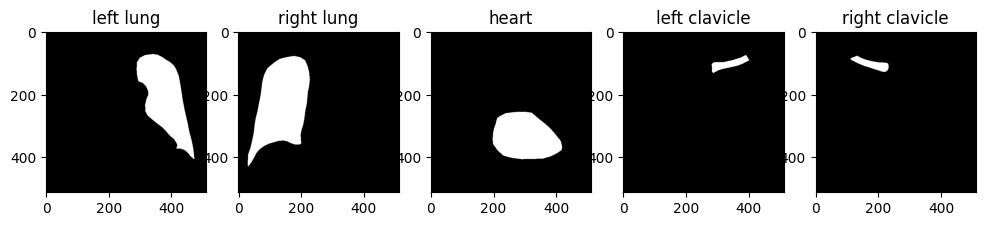

In [ ]:
N = 10  # Change this number to visualize another labelmap
plt.figure(figsize=(12,5))
titles = ['left lung', 'right lung', 'heart', 'left clavicle', 'right clavicle']
for i in range(labels.shape[-1]):
  plt.subplot(1,labels.shape[-1],i+1)
  plt.imshow(labels[N,:,:,i], 'gray')
  plt.title(titles[i])

## 4.1. Show some images and labels from the dataset

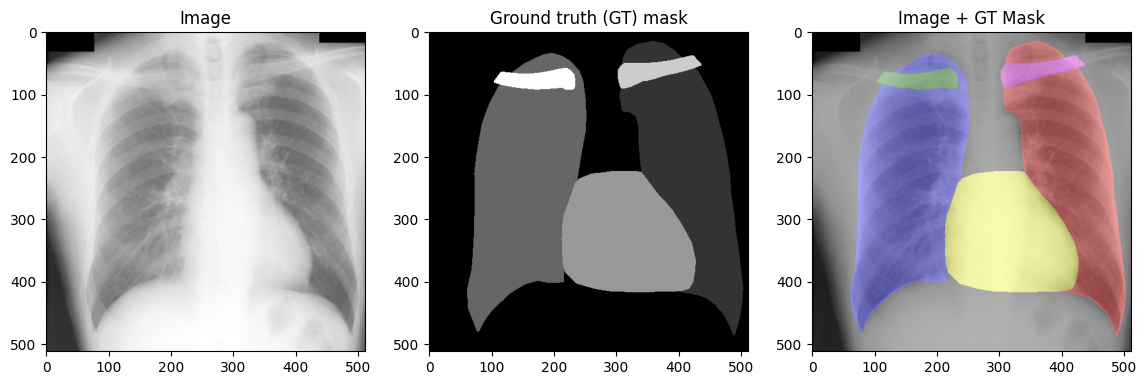

In [ ]:
N = 22  # Change this number to visualize another image-mask set
img = images[N]
mask = labels[N]
plot_image_and_label(img,mask)

# 5 - Preprocess data

In this section, we are going to:
1. Apply contrast limited adaptive histogram equalization (CLAHE) to the images. By applying this equalization, we are able to perform a better segmentation of the different structures present in the image. More info: https://en.wikipedia.org/wiki/Adaptive_histogram_equalization.
2. Normalize the images to zero-mean and unit variance. For that, we are going to use the following formula:

  $\frac{X-\mu}{\sigma + \epsilon}$

  Where X is the image, $\mu$ is the mean value of the image, $\sigma$ is the standard deviation and $\epsilon$ is a constant that prevents division by zero. This operation allows the network to train more efficiently.

- Hint to implement CLAHE: <a href="https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.equalize_adapthist"> Skimage - equalize_adapthist. </a>
- Hint to get the maximum value: [Numpy max](https://numpy.org/doc/stable/reference/generated/numpy.ndarray.max.html)
- Hints to normalize the values of the image: [hint 1](https://www.pythonpool.com/cv2-normalize/), [hint 2](https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga87eef7ee3970f86906d69a92cbf064bd)

In [ ]:
def preprocess_img(img):
  # TODO: Get the maximum value of the input image using np.max. Hint: https://numpy.org/doc/stable/reference/generated/numpy.ndarray.max.html
  max_value = np.max(img)
  # TODO: Apply CLAHE to the image. Hint: https://scikit-image.org/docs/stable/api/skimage.exposure.html#skimage.exposure.equalize_adapthist
  img = equalize_adapthist(img)
  # TODO: Normalize the image between 0 and max_value and then assign uint8 (np.uint8) type. Use CV2.NORM_MINMAX as norm_type. Hint: https://www.pythonpool.com/cv2-normalize/, https://docs.opencv.org/4.x/d2/de8/group__core__array.html#ga87eef7ee3970f86906d69a92cbf064bd
  img = cv2.normalize(img, None, 0, max_value, cv2.NORM_MINMAX).astype(np.uint8)
  return img

def normalize_img(img, epsilon=1e-10):
  #TODO: Normalize the image to zero mean and unit variance. See formula above.
  img_norm = (img - np.mean(img)) / (np.std(img) + epsilon)
  return img_norm

In [ ]:
X = np.zeros(images.shape)
y = labels.astype(np.float32)
for i, (img, lbl) in enumerate(tqdm(zip(images,labels), total=len(images))):
  img_preprocessed = preprocess_img(img) # TODO: Use the corresponding formula from above
  img_norm = normalize_img(img_preprocessed) # TODO: Use the corresponding formula from above
  X[i] = img_norm

  0%|          | 0/247 [00:00<?, ?it/s]

## 5.1 - Show some images and labels from the dataset afer being preprocessed and normalized

Here, we are going to inspect the data by plotting the image and mask of a given example, as well as their histograms. Change the value of **N** to inspect other examples. Remember that **N** must be a value contained within the bounds of the array or arrays in consideration.

Image mean: 2.42861286636753e-17
Image std: 0.9999999999983454
Labelmap mean: 0.10247726738452911
Labelmap std: 0.3032751679420471


Text(0.5, 1.0, 'Mask histogram')

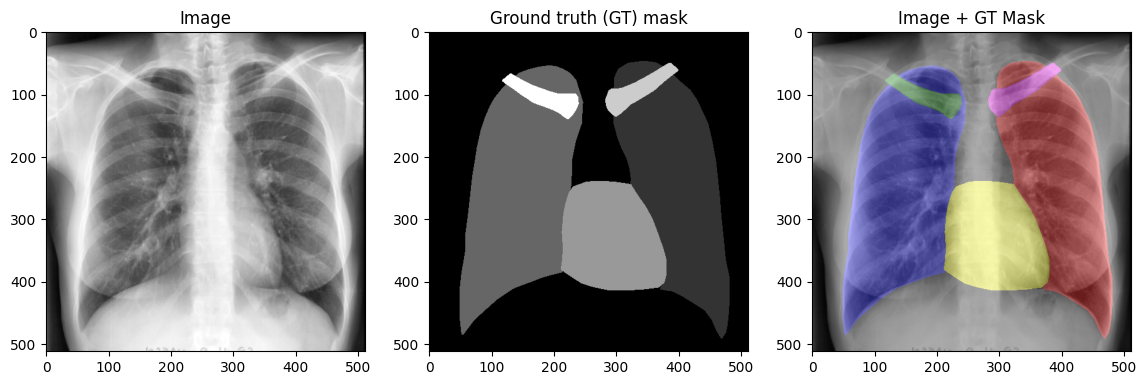

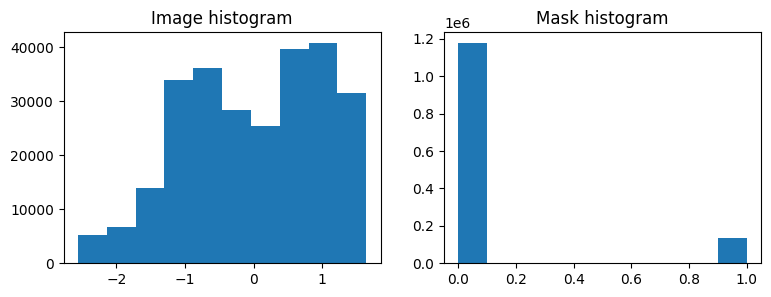

In [ ]:
N = 0  # Change this number to open another set of image-mask
plot_image_and_label(X[N],y[N],values_255=False)
print(f"Image mean: {X[N].mean()}")
print(f"Image std: {X[N].std()}")
print(f"Labelmap mean: {y[N].mean()}")
print(f"Labelmap std: {y[N].std()}")
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
plt.hist(X[N].flatten())
plt.title("Image histogram")
plt.subplot(1,2,2)
plt.hist(y[N].flatten())
plt.title("Mask histogram")

## 5.2 - Split the data


Split dataset into training and testing sets
* HINT: [sklearn - Train/Test slipt](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
* Use **random_state=42** (for reproducibility purposes)
* Use **shuffle=True**
* Use **test_size=0.2**

In [ ]:
from sklearn.model_selection import train_test_split
# TODO: Implement the code needed to split the data as detailed above (approx. 1 line)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

Let's check now how many data we have in each array obtained from the split-

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(197, 512, 512)
(197, 512, 512, 5)
(50, 512, 512)
(50, 512, 512, 5)


## 5.3 - Show some images and labels from the training dataset

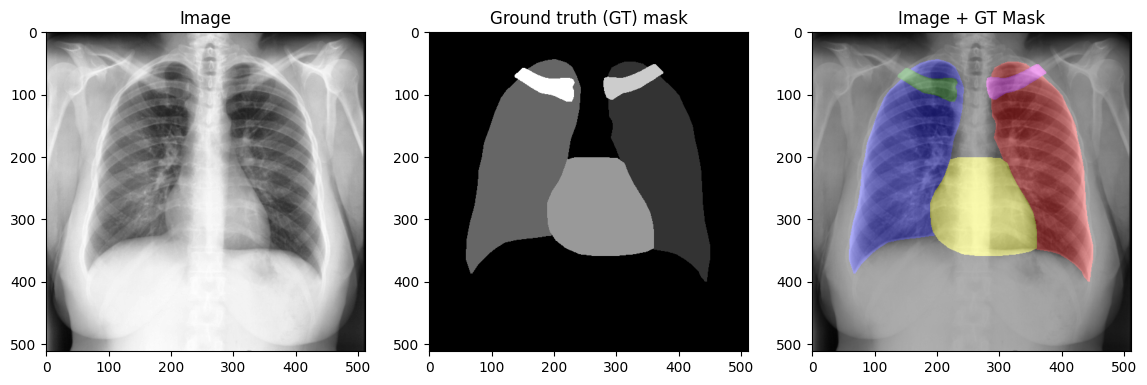

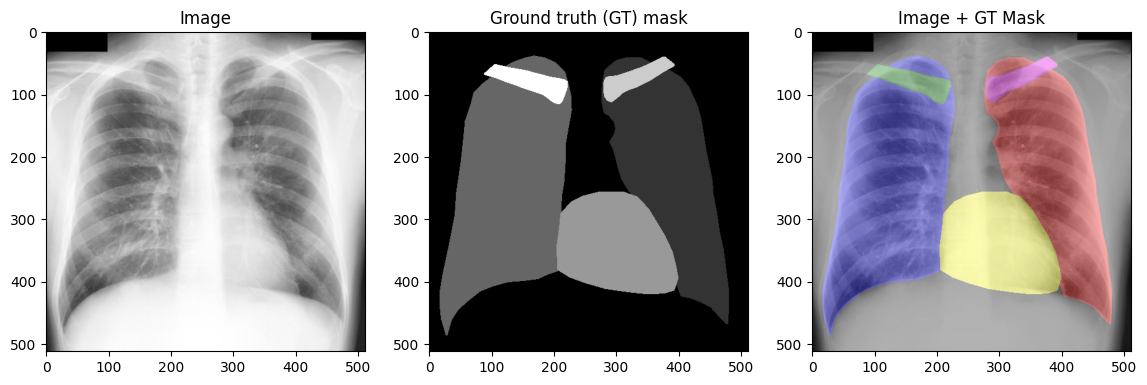

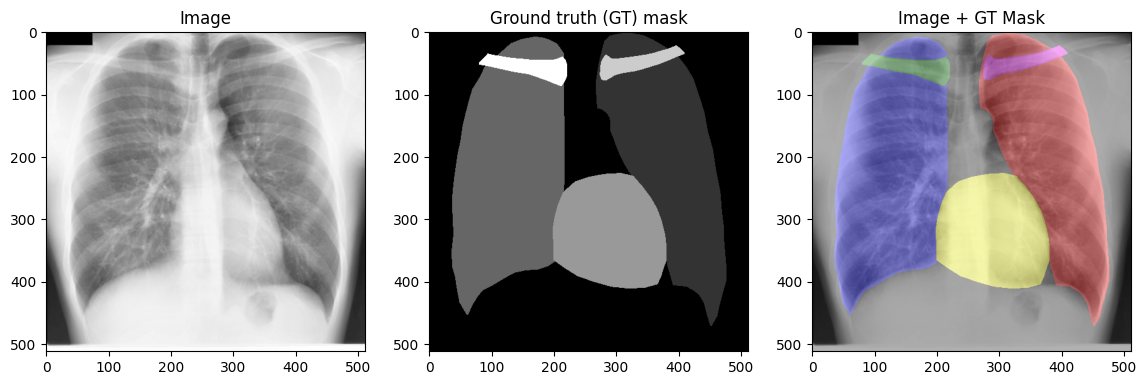

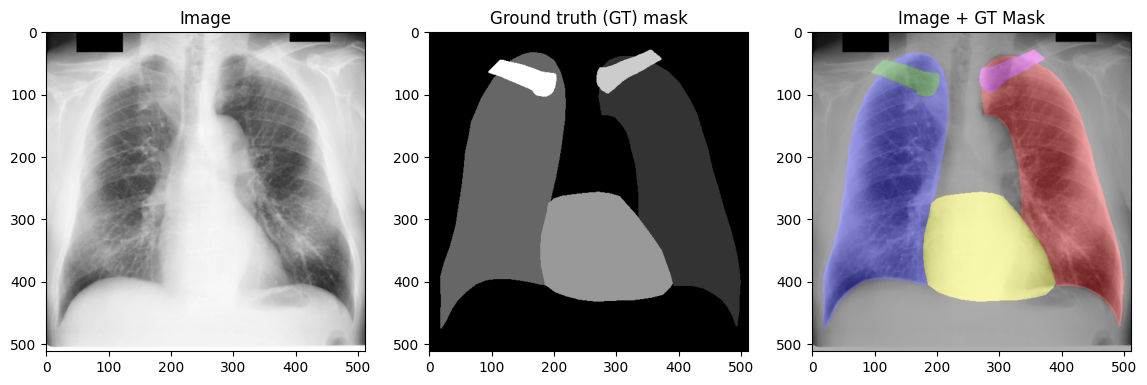

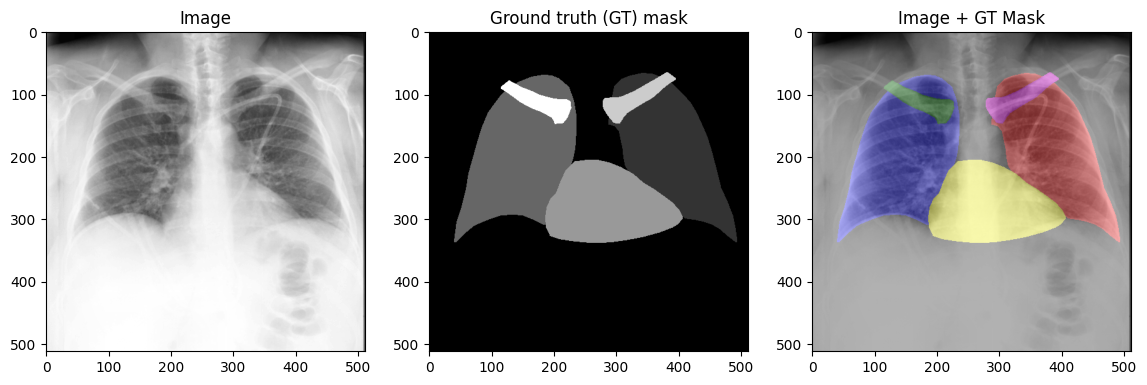

In [ ]:
# Sanity check: show some images and mask from the training data
indx = np.random.randint(0, len(X_train), 5)

for i in indx:
  plot_image_and_label(X_train[i], y_train[i], values_255=False)

# 6 - Build the U-Net model

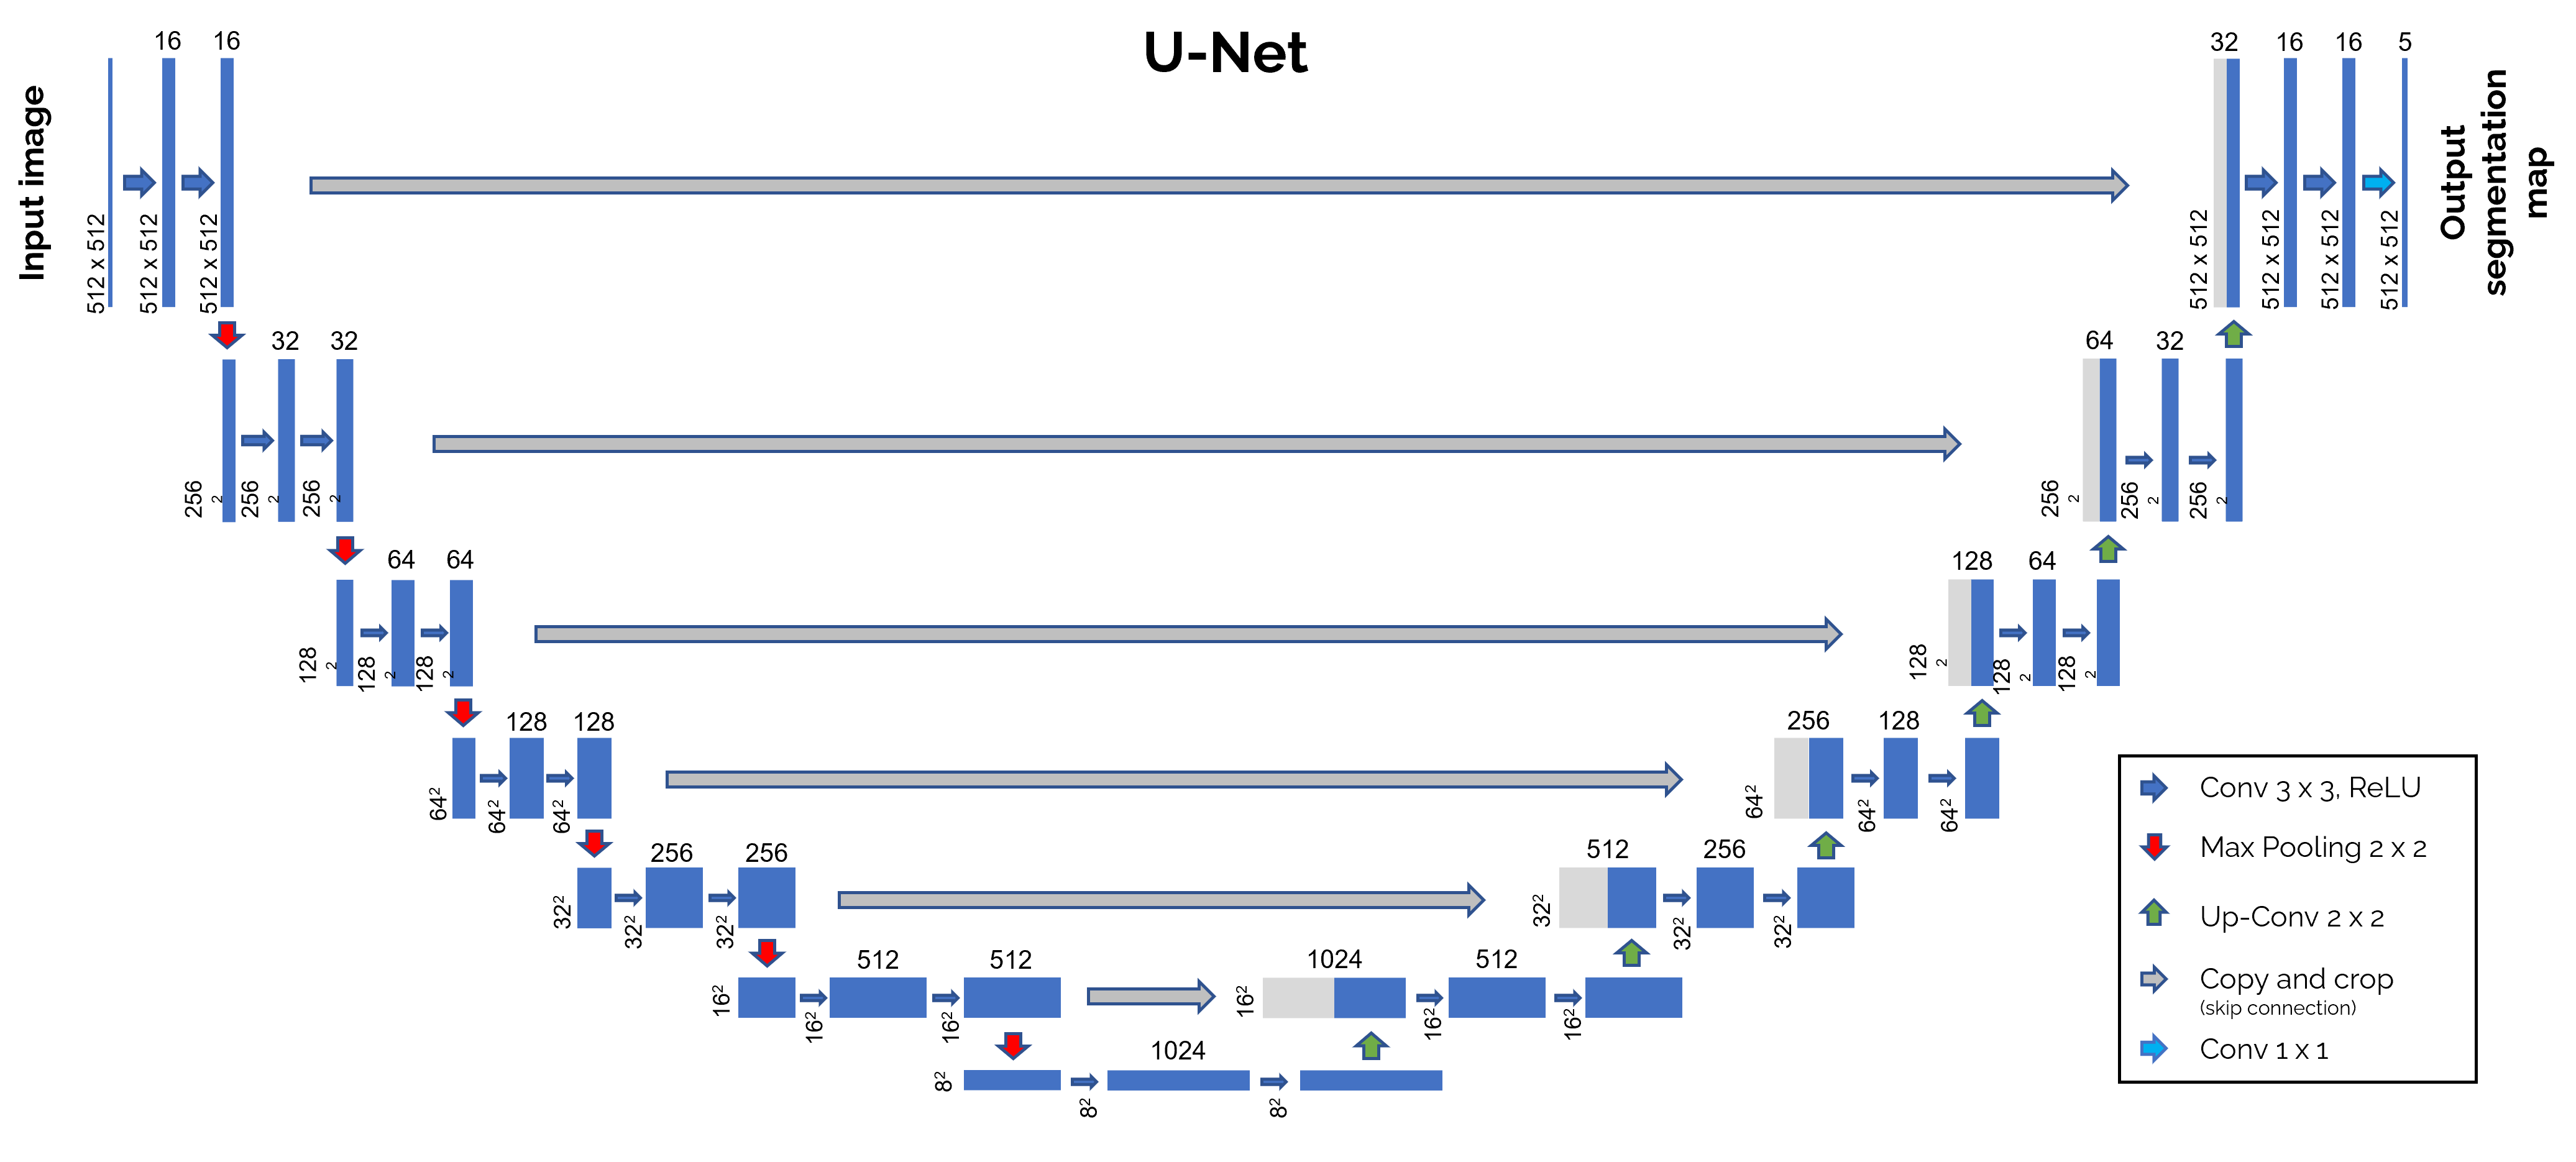

Once we have verified that all our images and labels are correctly preprocessed, split and adapted, we are going to build our **U-Net** segmentation model. The U-Net model is composed of two main branches: an encoder and a decoder. The **encoder** is the block that downsamples the image, encoding the information into a smaller tensor, and the **decoder** decodes this information by upsampling the tensors into a larger image.

In the **U-Net** architecture we have different types of layers, which we will learn to implement:
* **Convolutional Layers** (Conv2D). More info [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).
* **Max Pooling Layers** (MaxPooling2D). More info [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D).
* **Transpose Convolutions** (Conv2DTranspose). Not to be confused with deconvolution, although they are sometimes mistakenly called as such! More info [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose).
* **Skip connections**. These are connections between the encoder and the decoder. These connections allow us to transfer high spatial resolution information between the encoder and the decoder, solving the problem of obtaining low-resolution segmentations derived from coarse feature maps. These allow out model to use *fine-grained* details learned in the encoder part to construct an image in the decoder part. They are also used in other types of architectures, also used for classification tasks. More info on skip connections [here](https://www.analyticsvidhya.com/blog/2021/08/all-you-need-to-know-about-skip-connections/).

## 6.1 - Define the input to the U-Net

In [ ]:
# Define the input image size (width, height, channels) and the number of classes
img_w, img_h = images.shape[1], images.shape[2]
img_c = 1
mask_c = labels.shape[3]

## 6.2 - Build the Encoder (Downsampling Block)

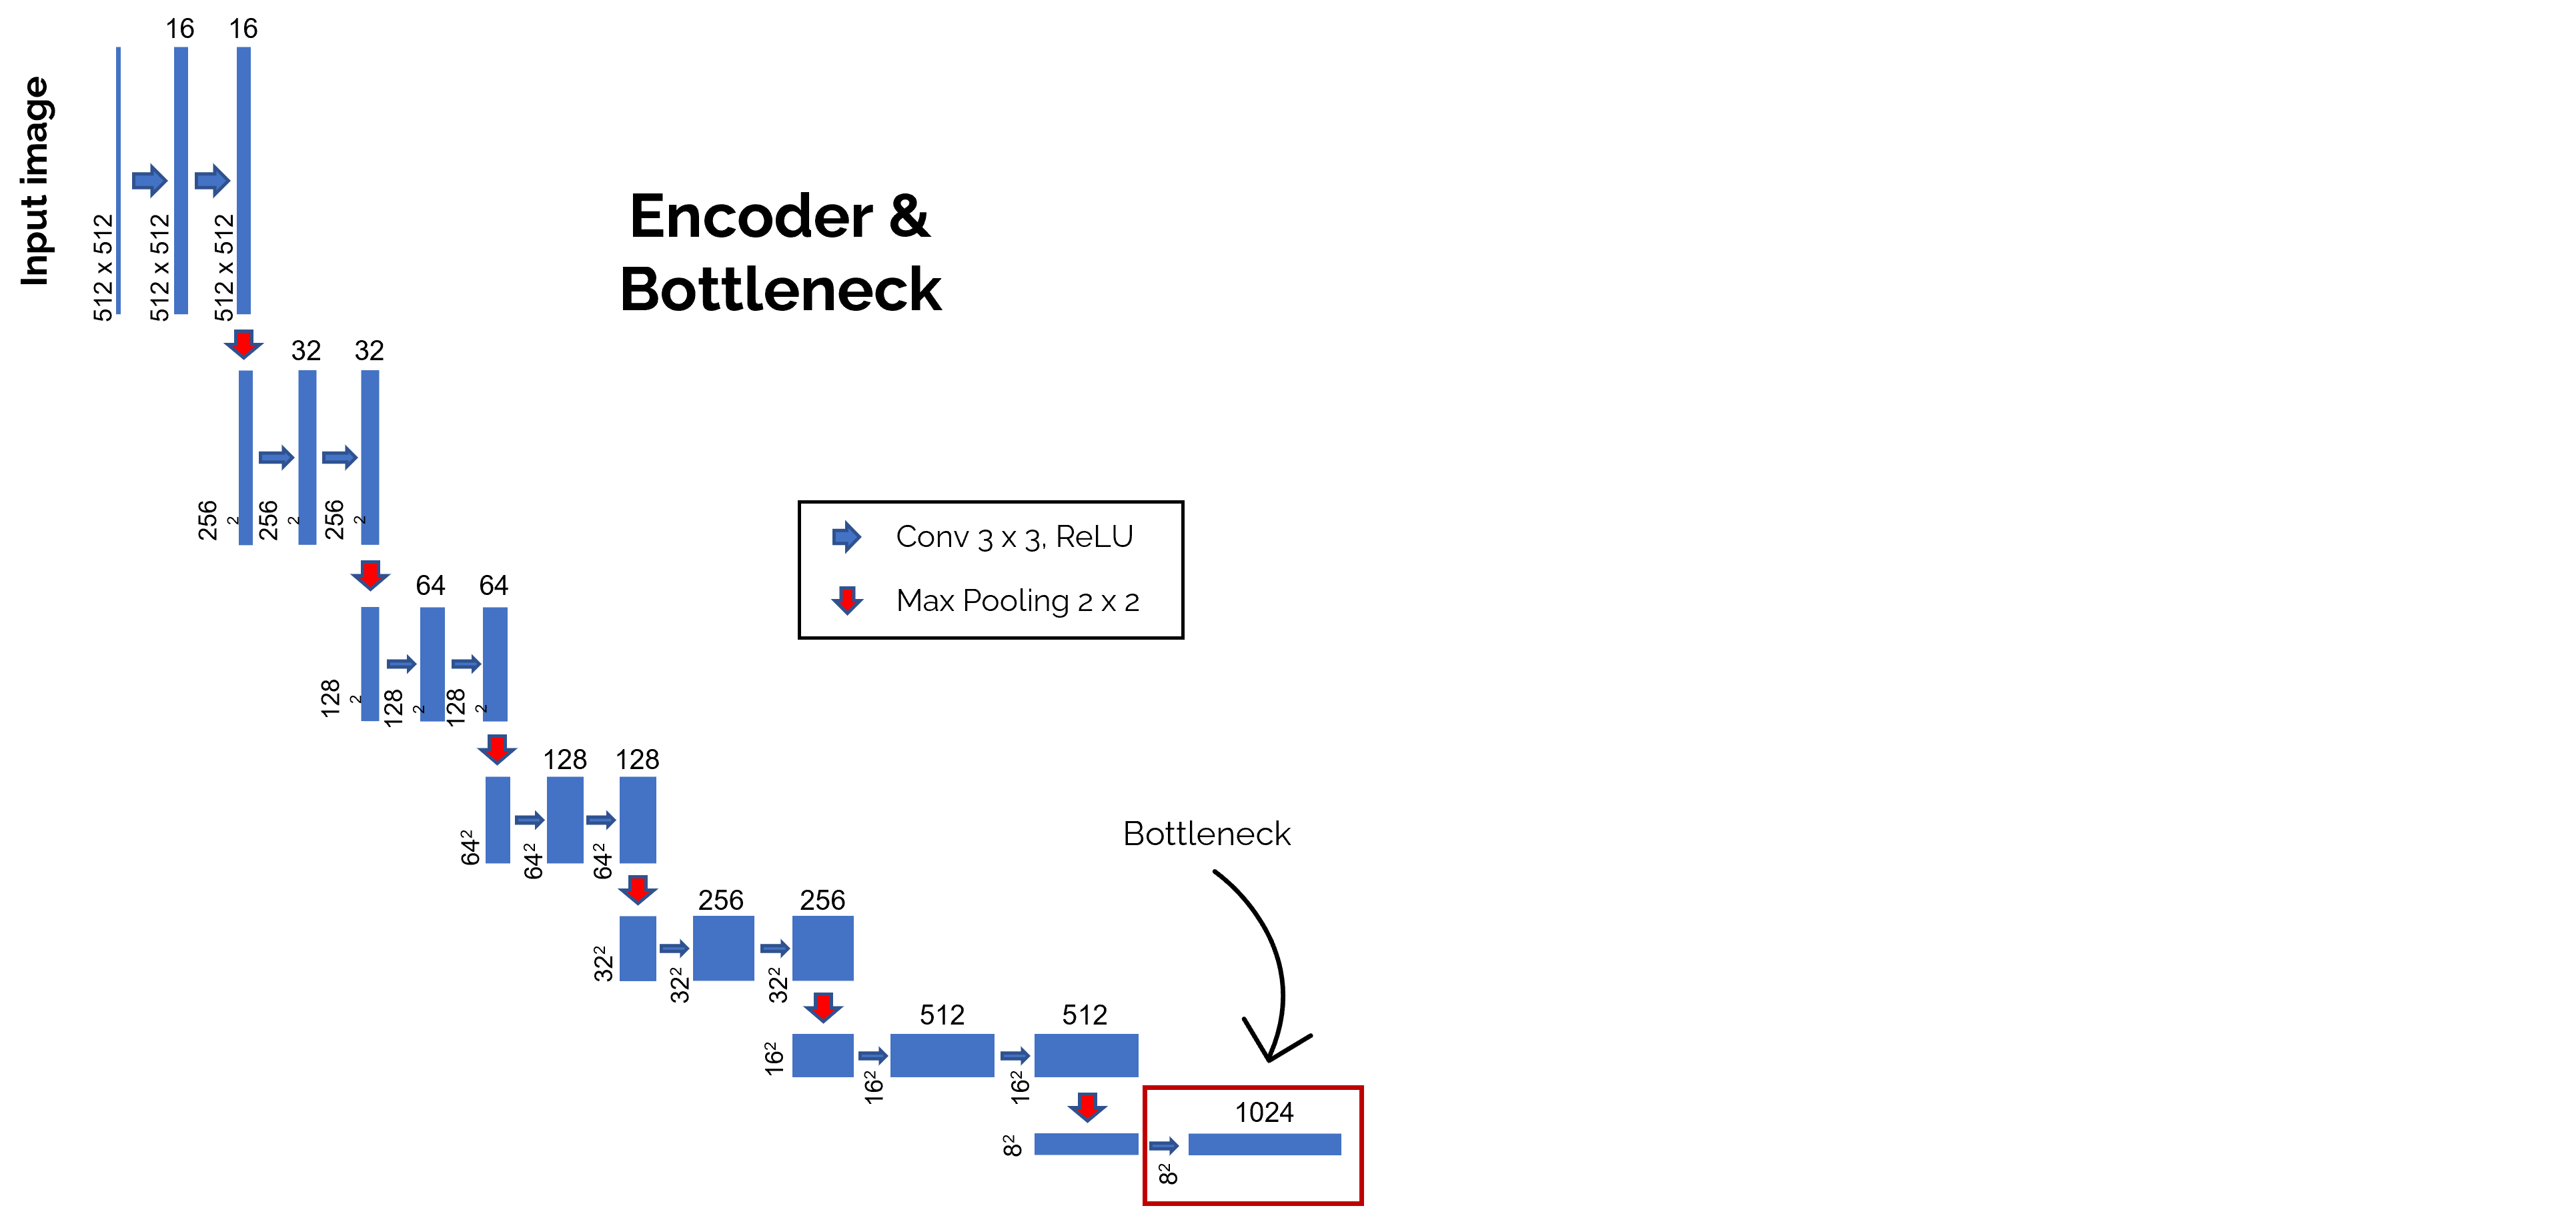

The **encoder** is a stack of various `conv_blocks`:

Each `conv_block()` is composed of 2 **Conv2D** layers  with ReLU activations. We will apply **Dropout**, and **MaxPooling2D** to some conv_blocks, as you will verify in the following sections, specifically to the last two blocks of the downsampling. The function will  return two tensors:

- `next_layer`: That will go into the next block.
- `skip_connection`: That will go into the corresponding decoding block.

**Note**: If `max_pooling=True`, the `next_layer` will be the output of the MaxPooling2D layer, but the `skip_connection` will be the output of the previously applied layer (Conv2D or Dropout, depending on the case). Else, both results will be identical.

**Exercise**: Implement `conv_block(...)` by filling the code blocks missing, indicated with ***#TODO***. Here are the instructions for each step in the `conv_block`, or contracting block:

First, add two **Conv2D** (2D convolutional) layers (HINT: [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)) with a number of filters equal to `n_filters`, kernel size of 3, ReLU non-linear activation and `he_normal` as kernel initializer. The padding and stride should be such that the output tensor size is equal to the size of the input tensor.

Next,
* if `dropout_prob` > 0, then add a Dropout layer with parameter `dropout_prob`
* If `max_pooling` is set to True, then add a MaxPooling2D layer with 2x2 pool size

In the code there are comments that show you where to introduce the code.

**Hint**: In all the layers/functions/components/operations you include, you should specify, at the end of the statement, the tensor to which you want to apply the operation, example:

`outputs = conv2D(XXX, XXX, XXX, XXX)(inputs)`


In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block

    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns:
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    # TODO: Add two convolutional layers with a number of filter equal to n_filters, kernel size of 3, ReLU non-linear activation and "he_normal" as kernel initializer.
    # The padding and stride should be such that the output tensor size is equal to the size of the input tensor.
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    # TODO: if dropout_prob > 0, add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:
      conv = Dropout(dropout_prob)(conv)
    # TODO: if max_pooling is True, add a MaxPooling2D with 2x2 pool_size. Else, 'next_layer' will be the same as 'conv'.
    if max_pooling:
      next_layer = MaxPooling2D(pool_size = (2,2), strides=2)(conv)
    else:
      next_layer = conv
    # TODO: Save 'conv' in a variable called 'skip_connection', so that 'conv' is passed to the corresponding decoding step through a skip connection.
    skip_connection = conv

    return next_layer, skip_connection

Let's check if the code above works by running the following cell. It should print each of the layers of the encoder without errors.

In [ ]:
input_size=(img_h, img_w, img_c)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model = tf.keras.Model(inputs=inputs, outputs=cblock1)

#Print model's layers
for layer in model.layers:
    print(layer.name)

input_layer
conv2d
conv2d_1
max_pooling2d


## 6.3 - Build the Decoder (Upsampling Block)

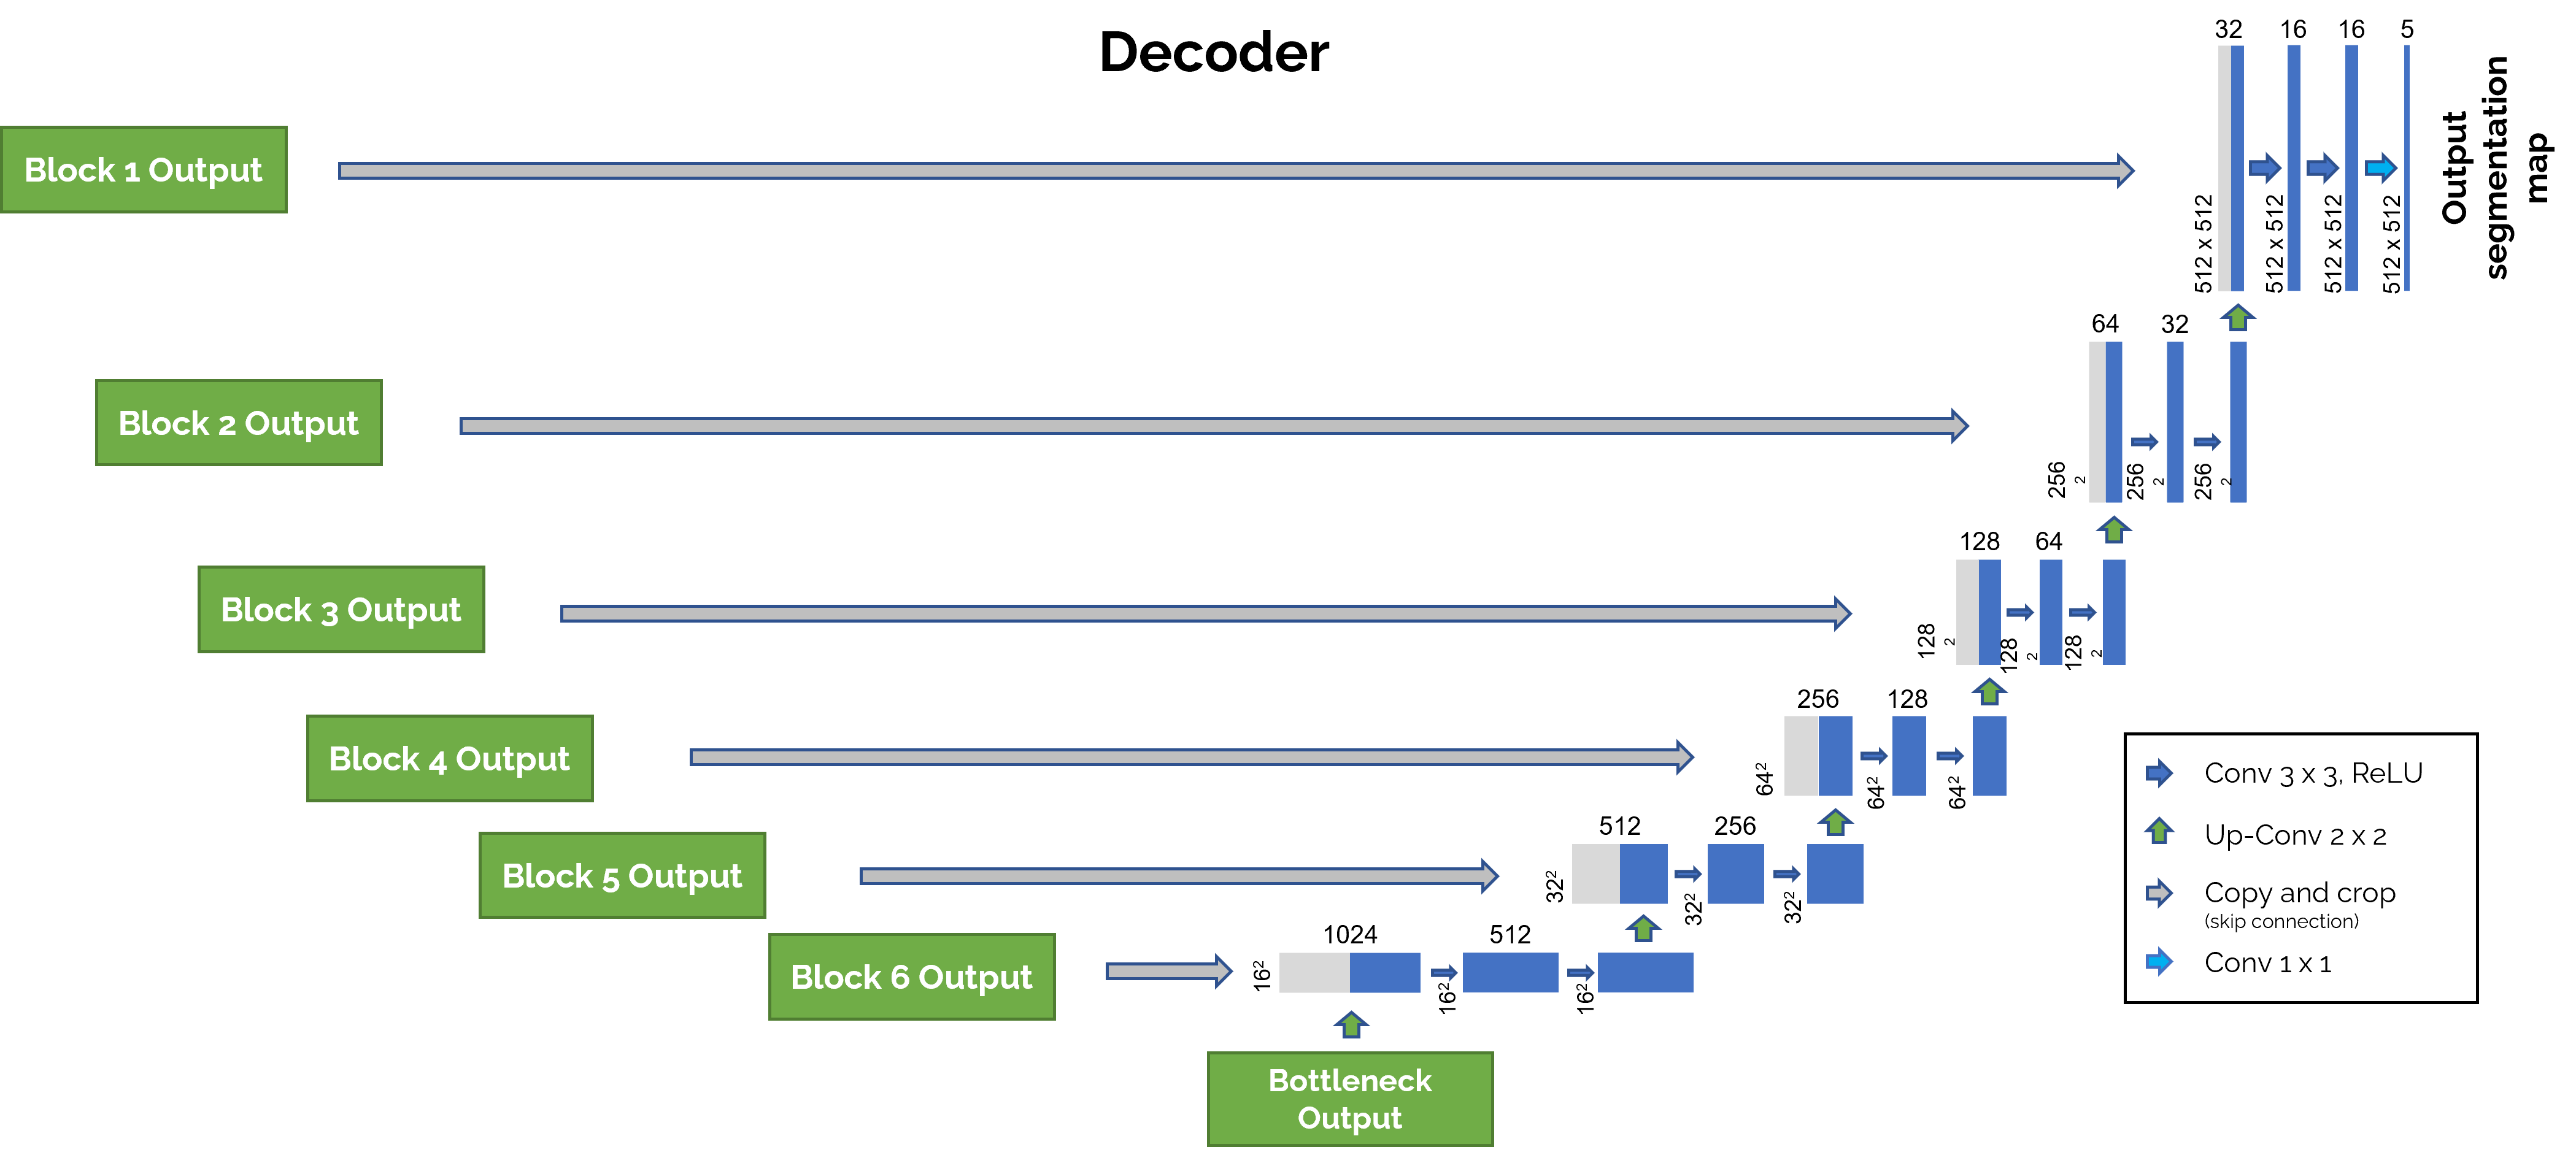

The **decoder**, or upsampling block, upsamples the features back to the original image size. At each upsampling level, you'll take the output of the corresponding encoder block and concatenate it with the output of the upsampling step (transpose convolution) before feeding everything to the next decoder block.

The decoder is a stack of various `upsampling_blocks`, which you will have to implement. Each `upsampling_block` is composed of one transpose convolutional layer (**Conv2DTranspose**, more info [here](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)), which performs the upsampling step, followed by a concatenation (**concatenate**) of the information that comes from the corresponding encoding block passed through a skip connection (see above for more details in skip connections) and the output of this first **Conv2DTranspose** layer. Additionally, we have two **Conv2D** layers set to the same parameters as in the encoder.

**Exercise:** Implement `upsampling_block(...)` by filling the code blocks missing, indicated with ***#TODO***:

The function `upsampling_block` takes the arguments `expansive_input` (which is the input tensor from the previous layer) and `contractive_input` (the input tensor from the corresponding encoder block passed through a skip connection). In this function we have:

  * One **Conv2DTranspose** that will take `n_filters` with kernel shape (3,3) and a stride of (2,2). The padding shold be set in a way such that the output has the same height/width dimension as the input. This layer is applied to `expansive_input` (input tensor from the previous layer). Hint: [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose).
  * One **concatenate** layer that merges the output of the previous upsampling step (**Conv2DTranspose**) with the output of the corresponding encoder block passed through a skip connection. Both tensors should be concatenated through the third axis (axis=3). Hint: [concatenate](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate).
  * Two **Conv2D** layers with the same parameters as those implemented in the downsampling block. Hint: [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D).

**Note:** For next steps, recall that the number of filters and dimensions in the encoder should match to those of the decoder so that the reconstructed image is of the same size as the input.

In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block

    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns:
        conv -- Tensor output
    """

    # TODO: Implement a Conv2DTranspose layer that will take `n_filters` with
    # kernel shape (3,3) and a stride of (2,2). The padding shold be set in a way such
    # that the output has the same height/width dimension as the input.
    # HINT: This layer is applied to `expansive_input` (input tensor from the previous layer).

    upsamp = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same')(expansive_input)

    # TODO: Implement a concatenate layer that merges the output of the previous
    # upsampling step with the output of the corresponding encoder block
    # passed through a skip connection. Both tensors should be concatenated
    # through the third axis (axis=3).

    merge = concatenate([upsamp, contractive_input], axis=3)

    # TODO: Implement two Conv2D layers with the same parameters as those
    # implemented in the downsampling block.

    conv = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(merge)
    conv = Conv2D(n_filters, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(conv)

    return conv

Let's check if the code above works by running the following cell. It should print each of the layers of the decoder without errors.

In [ ]:
input_size1 = (64, 64, 32)
input_size2 = (128, 128, 32)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

for layer in model1.layers:
    print(layer.name)

input_layer_1
conv2d_transpose
input_layer_2
concatenate
conv2d_2
conv2d_3


## 6.4 - Build the Model

In this part, you'll put everything together, by chaining the **encoder**, **bottleneck** (conv block without pooling), and **decoder**! You'll need to specify the number of output classes, which for this particular set would be 5. That's because we are predicting 5 different labelmaps, 1 for each class present in this chest X-ray dataset (left lung, right lung, heart, left clavicle, right clavicle).

For the function `unet_model`, specify the input shape, number of filters, and number of classes (5 in this case).

For the first half of the model:

* Begin with the first conv block (`cblock1`), which takes the inputs to the model and the number of filters.
* Then, chain the first output element of each block to the input of the next convolutional block.
* Next, double the number of filters at each step.
* Beginning with `conv_block6`, add `dropout` of 0.3
* For the final conv_block (`LSBlock`), which is the bottleneck (Latent Space), set `dropout` to 0.3 again, and turn off max pooling. (Here you should have `n_filters=n_filters*64`)

For the second half:
* From here, at each step, use half the number of filters of the previous block
* In the first upsampling block, use `LSblock[0]` as expansive_input and `cblock6[1]` as contractive_input.
* Use the diagram of the architecture provided (see above) to find out which number of filters should be used in each step.
* In each step, chain the output of the previous block as `expansive_input` and the corresponding information from the encoder passed through the skip connection as `contractive_input`.
* Note that you must use the second element of the contractive block before the max pooling layer (e.g., `cblock6[1]`, not `cblock[0]`).
* Finally, `conv_final` is a Conv2D that takes the number of classes as the number of filters, a kernel size of 1, and the padding is such that the output has the same shape as the input. At this point, in the definition of this convolutional layer, you must also include an appropriate activation function. Note that the output of `conv_final` is the output of your model.

In [ ]:
def unet_model(input_size=(256, 256, 1), n_filters=32, n_classes=1):
    """
    Unet model

    Arguments:
        input_size -- Input shape
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns:
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # FIRST HALF: Contracting Path (encoding)
    ## TODO: Add a conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs, n_filters)
    ## TODO: Chain the first element of the output of each block to be the input of the next conv_block.
    ## TODO: Double the number of filters at each new step
    cblock2 = conv_block(cblock1[0], n_filters*2)
    cblock3 = conv_block(cblock2[0], n_filters*4)
    cblock4 = conv_block(cblock3[0], n_filters*8)
    cblock5 = conv_block(cblock4[0], n_filters*16)
    ## TODO: In the next conv_block, include a dropout of 0.3
    cblock6 = conv_block(cblock5[0], n_filters*32, dropout_prob=0.3)
    ## TODO: In the next conv_block, which is the bottleneck (Latent space), include a dropout of 0.3 and avoid the max_pooling layer
    LSblock = conv_block(cblock6[0], n_filters*64, dropout_prob=0.3, max_pooling=False)

    # SECOND HALF: Expanding Path (decoding)
    ## TODO: Add the first upsampling_block. From here,at each step, use half the number of filters of the previous block.
    ## HINT: Use the diagram of the architecture provided to find out which number of filters should be used in each step.
    ## HINT: In this first upsampling block, use the LSblock[0] as expansive_input and cblock6[1] as contractive_input
    ublock6 = upsampling_block(LSblock[0], cblock6[1], n_filters*32)

    ## TODO: Chain the output of the previous block as expansive_input and the corresponding contractive block output.
    ## HINT: In the contractive input, note that you must use the second element, i.e., before the maxpooling layer!
    ublock5 = upsampling_block(ublock6, cblock5[1], n_filters*16)
    ublock4 = upsampling_block(ublock5, cblock4[1], n_filters*8)
    ublock3 = upsampling_block(ublock4, cblock3[1], n_filters*4)
    ublock2 = upsampling_block(ublock3, cblock2[1], n_filters*2)

    ## HINT: By this time, the next block should have a number of filters equal to n_filters
    ublock1 = upsampling_block(ublock2, cblock1[1], n_filters)

    ## TODO: Add a Conv2D layer with n_classes filter, kernel size of 1 and a padding type
    ## which makes the output have the same shape as the input. HINT: See Conv2D documentation.
    conv_final = Conv2D(n_classes, (1, 1), padding='same', activation = 'softmax')(ublock1)

    model = tf.keras.Model(inputs=inputs, outputs=conv_final)

    return model

## 6.5 - Initialize model and summary

In [ ]:
# TODO: Initialize U-Net model. Input size: (img_h, img_w, img_c); Number of filters: 16. Number of output classes: equal to mask_c (# classes)
unet = unet_model(input_size = (img_h, img_w, img_c), n_filters = 16, n_classes = mask_c)  # TODO

In [ ]:
# Model summary
unet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 512, 512, 1)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 512, 512, 16)   │            160 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 512, 512, 16)   │          2,320 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 256, 256, 16)   │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 256, 256, 32)   │          9,248 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 128, 128, 32)   │              0 │ conv2d_7[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 128, 128, 64)   │         18,496 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 128, 128, 64)   │         36,928 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 64, 64, 64)     │              0 │ conv2d_9[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_10 (Conv2D)        │ (None, 64, 64, 128)    │         73,856 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_11 (Conv2D)        │ (None, 64, 64, 128)    │        147,584 │ conv2d_10[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 32, 32, 128)    │              0 │ conv2d_11[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_12 (Conv2D)        │ (None, 32, 32, 256)    │        295,168 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_13 (Conv2D)        │ (None, 32, 32, 256)    │        590,080 │ conv2d_12[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 16, 16, 256)    │              0 │ conv2d_13[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_14 (Conv2D)   

 Total params: 34,604,181 (132.00 MB)

 Trainable params: 34,604,181 (132.00 MB)

 Non-trainable params: 0 (0.00 B)

## 6.6 - Loss Function

In semantic segmentation, you need as many masks as object classes you have. In the dataset you're using, each pixel in every mask has been assigned a probability that it belongs to a certain class, from 0 to 1 (binary). For every output mask, those pixels that have a probability higher than 0.5 (threshold), will have a pixel contributing to the segmentation.

In [ ]:
# Dice coefficient
def dice_coef(y_true, y_pred, smooth=100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

In [ ]:
# TODO: Define Adam optimizer. HINT: see https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# TODO: Define BinaryCrossEntropyLoss. HINT: see https://www.tensorflow.org/api_docs/python/tf/keras/losses
loss = tf.keras.losses.BinaryCrossentropy()
# TODO: Compile the model. Use 'accuracy' and dice_coef (without quotes), i.e., ['accuracy',dice_coef], as metrics.
unet.compile(optimizer=opt,
             loss=loss,
             metrics=['accuracy',dice_coef]) #HINT: Use accuracy and dice coefficient as metrics

# 7 - Train the Model

In this section, we are going to train (fit) the model. In this process, the weights and other parameters of the model will be updated iteratively. Typically, the larger and more diverse the data, the better the performance and, therefore, the generalization of our model to new data.

Consequently, we are going to fit our model considering the following:
* Train for 200 epochs.
* Use a batch size of 16 images.
* 25% of the training data used for validation.
* Use a callback which incorporates Early Stopping in the training procedure. This Early Stopping is going to use `val_dice_coef` (mode='max') metric to decide whether to early stop or not. Early Stopping patience of 10, verbose option activated and restore the best weights (`restore_best_weights=True`).

**HINTS**:
* [TensorFlow train and evaluate](https://www.tensorflow.org/guide/keras/train_and_evaluate)
* [TensorFlow - fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit)
* [Usage of callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks) and [Early Stopping](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)

In [ ]:
epochs =  200 #TODO
batch_size = 16 #TODO
es = tf.keras.callbacks.EarlyStopping(monitor = 'val_dice_coef', patience = 10, mode = 'max', verbose = 1, restore_best_weights=True) #TODO
cb = [es]  #TODO. Include the callbacks in an array, separated with commas. If only one callback, commas not needed.

In [ ]:
model_history = unet.fit(X_train, y_train, batch_size, epochs, callbacks = cb, validation_split = 0.25)  # TODO

Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 157s 9s/step - accuracy: 0.1194 - dice_coef: 0.1361 - loss: 0.7051 - val_accuracy: 0.0808 - val_dice_coef: 0.1355 - val_loss: 0.3929
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 655ms/step - accuracy: 0.0895 - dice_coef: 0.1392 - loss: 0.3687 - val_accuracy: 0.1464 - val_dice_coef: 0.1797 - val_loss: 0.3041
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 734ms/step - accuracy: 0.1749 - dice_coef: 0.1799 - loss: 0.2840 - val_accuracy: 0.2619 - val_dice_coef: 0.2237 - val_loss: 0.2706
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 10s 674ms/step - accuracy: 0.2566 - dice_coef: 0.2202 - loss: 0.2565 - val_accuracy: 0.2655 - val_dice_coef: 0.2534 - val_loss: 0.2515
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 740ms/step - accuracy: 0.2582 - dice_coef: 0.2447 - loss: 0.2430 - val_accuracy: 0.2648 - val_dice_coef: 0.2694 - val_loss: 0.2416
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 9s 663ms/step - accuracy: 0.2577 - dice_coef: 0.2550 - loss: 0.2330 - val_accuracy: 0.2920 - 

### 7.1 - Plot Model Accuracy

Let's see how your model did! Let's plot the learning curves of our model during the training and validation.

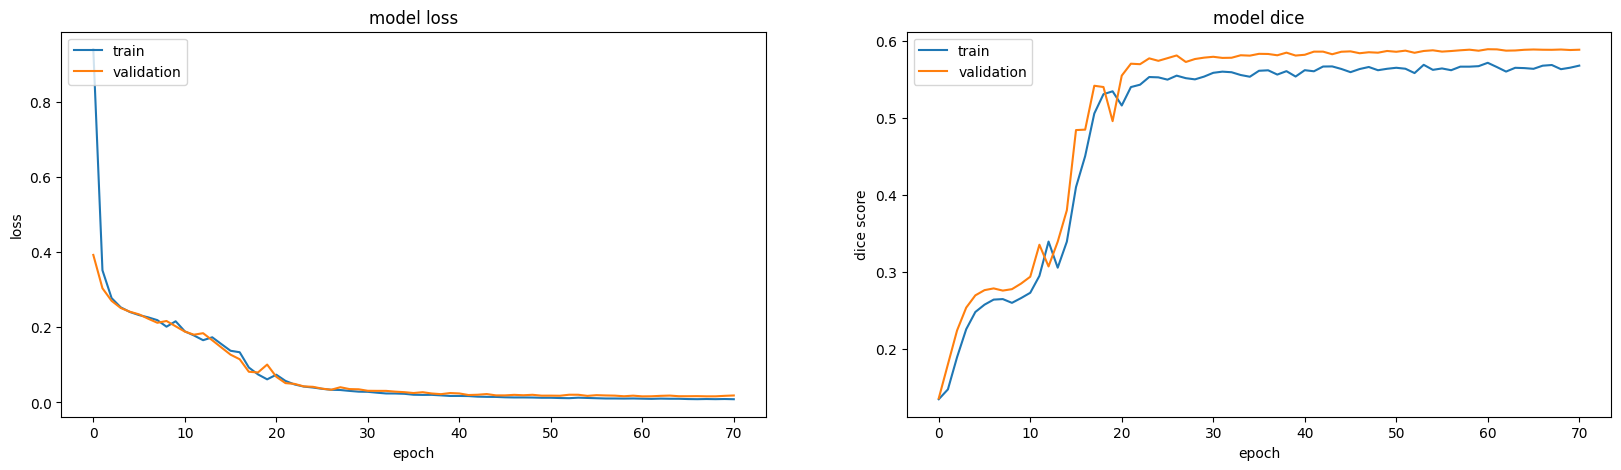

In [ ]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

# summarize history for loss
plt.subplot(1,2,2)
plt.plot(model_history.history['dice_coef'])
plt.plot(model_history.history['val_dice_coef'])
plt.title('model dice')
plt.ylabel('dice score')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

---

**ANSWER TO THE FOLLOWING QUESTIONS**

---
**1. EXPLANATION OF THE U-NET TRAINING PROCESS: DESCRIBE WHAT YOU OBSERVE ON THE LEARNING CURVES**

1) Model loss (left plot)
- This plot shows the training (blue curve) and validation (orange curve) loss that are decreasing over the epochs.
- At the start, both the training and validation losses are quite high, but they drop significantly during the initial epochs, showing that the model is effectively learning the features.
- By around epoch 20, the curves begin to flatten and converge, indicating that the model has stabilized and is neither overfitting nor underfitting.
- The small difference between the training and validation losses suggests that the model generalizes well to new, unseen data.
- Early stopping is implemented monitoring the dice coefficient of the validation set. The training has been stopped at epoch 71, as the dice coefficient of the validation set has not improved after 10 epochs
(patience=10). Therefore, the model weights are restored from the end of the best epoch, which yields epoch 61.

2) Dice coefficient (right plot)
- This plot illustrates the Dice score, a metric used to evaluate segmentation accuracy.
- The Dice score begins at a low value but quickly rises during the first 20 epochs, which aligns with the reduction in loss. This suggests that the model is effectively learning to predict segmentation masks.
- After the 20th epoch, the validation Dice score remains slightly above the training Dice score, possibly indicating some mild regularization effects or better generalization to the validation data.
- Both curves demonstrate steady improvement and stabilize around epochs 50 to 60, ultimately reaching a high Dice score of over 0.55.


---
**2. WHAT WOULD HAPPEN IF WE TOOK OUT THE SKIP CONNECTIONS BETWEEN THE ENCODER AND THE DECODER? HOW WOULD THAT AFFECT TO THE OUTPUT SEGMENTATION MAPS OBTAINED BY THE MODEL?**

- Skip connections between the encoder and decoder branch of the UNet are essential to preserve spatial information that is lost during downsampling the images in the encoder. It enables the decoder to access fine-grained details that are important for an accurate image segmentation.
- Without these skip connections, the decoder will only rely on the high-level feature maps that have been compressed by the encoder branch. This will lead to less precise/accurate segmentation maps and poorly delineated segmentations.



# 8 - Test the Model

Now, let's test the model on the independent test set (`X_test`). First, we are going to predict the outputs given the inputs (`X_test`). Later on, we will assign 1 to the probabilities greater than 0.5 (threshold). Else, they will be 0 (background).
1. HINT/ [keras-predict](https://www.tensorflow.org/api_docs/python/tf/keras/Model) returns an array with the output probability distribution (predictions)
2. Assign 1 to the predictions > 0.5, 0 otherwise.

In [ ]:
y_test_pred =  unet.predict(X_test)
print(y_test_pred.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 67s 26s/step
(50, 512, 512, 5)


In [ ]:
y_test_pred = np.where(y_test_pred > 0.5, 1.0, 0.0)

## 8.1 - Visualize some testing examples

Let's visualize some testing examples and compare GT vs predicted segmentations.

In [ ]:
def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice coefficient for comparing the similarity of two sets.
    """
    y_true_f = K.flatten(K.cast(y_true, 'float32')) # Cast y_true to float32
    y_pred_f = K.flatten(K.cast(y_pred, 'float32')) # Cast y_pred to float32
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

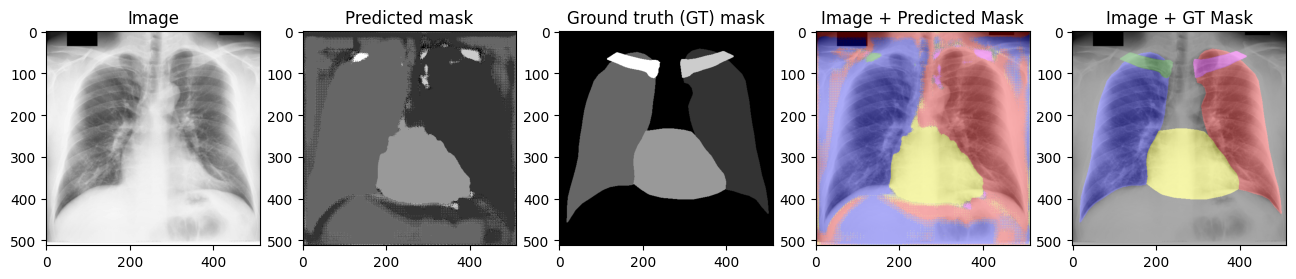

Dice score: 0.6216444969177246


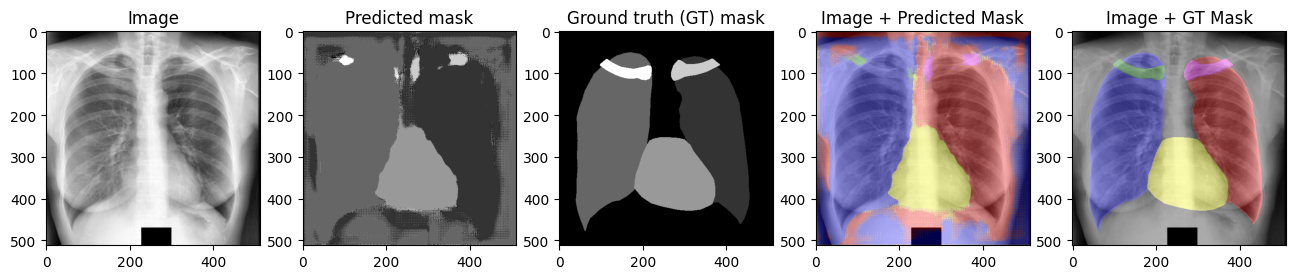

Dice score: 0.6326947808265686


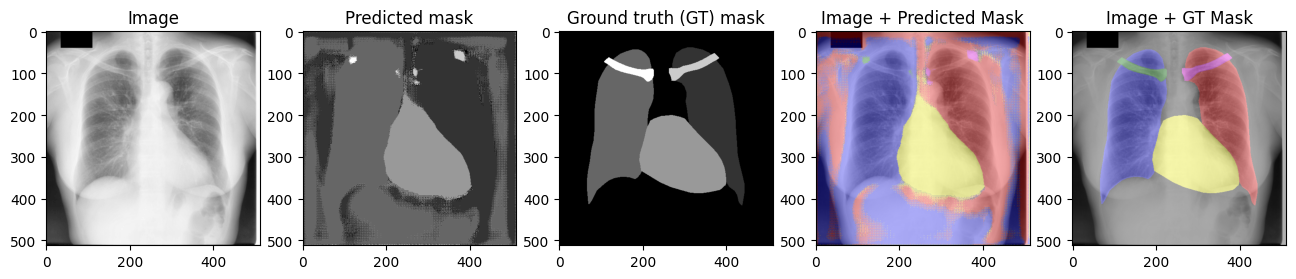

Dice score: 0.5320988297462463


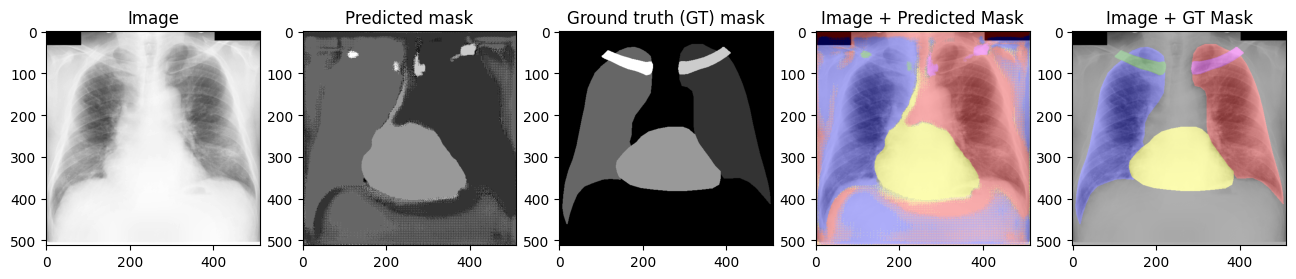

Dice score: 0.6001921892166138


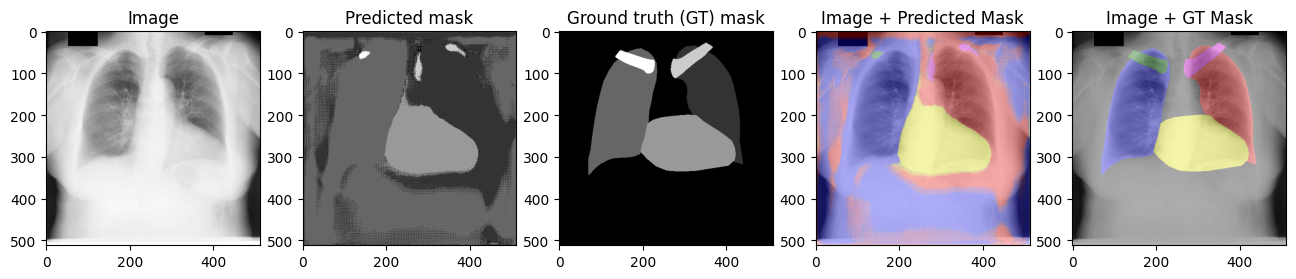

Dice score: 0.45808079838752747


In [ ]:
# Display some examples of predicted mask
indx = np.random.randint(0, len(X_test), 5)

for i in indx:
  plot_image_and_pred_label(X_test[i], y_test_pred[i], y_test[i], values_255=False)
  plt.show()
  print(f"Dice score: {dice_coef(y_test[i], y_test_pred[i])}")

## 8.2 - Test metrics

Finally, let's compute the performance of our model on the whole independent test set. We will use Dice score to assess how good our model performs on these unseen data.
* Use `dice_coef` function to compute the metric along the whole independent testing subset. This function was defined above (See section 6.6).
* Remember that `y_test_pred` is our array containing the predictions (already thresholded and with binary values (0 or 1)).  

In [ ]:
dice_coef(y_test, y_test_pred)  # TODO

<tf.Tensor: shape=(), dtype=float32, numpy=0.5838959>

---

**ANSWER TO THE FOLLOWING QUESTIONS**

---

**3. NAME OTHER PERFORMANCE METRICS THAT COULD HAVE BEEN USED TO EVALUATE THE PERFORMANCE OF OUR MODEL**

1) Pixel accuracy
- reflects the percentage of pixels in the predicted segmentation mask that are correctly classified as belonging to that organ according to the labeled ground truth (GT) mask.
- is simple and intuitive, providing a general measure of correctness. A higher accuracy corresponds to a better segmentation performance.
- may be misleading when there is a large imbalance between background pixels and organ pixels, as the high accuracy of the background class can dominate the score.

2) Intersection Over Union (IoU)/Jaccard index
- measures the overlap between the predicted segmentation mask and the ground truth mask, divided by their union. It captures how well the predicted mask matches the true organ region.
- is a robust metric for evaluating segmentation, as it penalizes both under-segmentation (missing organ regions) and over-segmentation (including extra regions). A higher IoU indicates better segmentation performance.
- is less sensitive to boundary precision

3) Hausdorff distance (HD)
- measures the maximum distance between points on the predicted mask and their closest points on the ground truth mask boundary.
- HD95: measures the maximum of the minimum distances between the predicted segmentation and the ground truth at the 95th percentile.
- a lower HD corresponds to a better image segmentation.

4) Precision
- measures the proportion of correctly predicted positive pixels (true positives so corresponding to a certain organ in one of the 5 segmentation masks) out of all pixels predicted as positive (true positives + false positives).
- a higher precision indicates fewer false positives, which is important when oversegmenting an organ could lead to errors in clinical applications.

5) Sensitivity/recall
- measures the proportion of correctly predicted positive pixels (true positives) out of all actual positive pixels (true positives + false negatives).
- a higher recall ensures the model captures most of the actual organ pixels, reducing undersegmentation.

6) f1-score
- harmonic mean of precision and recall, balancing the trade-off between false positives and false negatives.
- is particularly useful when there’s an imbalance between the size of the segmented organs and the background.

---

**4. WHAT OTHER ARCHITECTURES COULD HAVE BEEN USED FOR THIS SEGMENTATION TASK?**

Current model: UNet
- has symmetrical architecture with equal downsampling and upsampling layers.
- has skip connections that preserve spatial information.

SegNet
- also has an encoder-decoder architecture, but now max-pooling indices at the corresponding encoder layer are used in the decoding branch to upsample the layers.
- reduces complexity and is designed for efficiency, suitable for real-time and resource-constrained scenarios.


Residual UNet
- is a variation of UNet that incorporates residual connections within the architecture, so the convolutional blocks in the encoder and decoder branch.
- the residual connections can help to alleviate the vanishing gradient problem and improve the overall performance of the network.


UNet Transformers/UNETR
- consists of a transformer-based encoder and a convolutional-based decoder.
- including transformer blocks instead of CNN-blocks is particarly advantageous for capturing the global context on the image to perform the segmentation. However, the training is computationally demanding and requires large amounts of data.

Sliding window UNet Transformer/Swin UNETR
- includes adjustments in the transformer-based encoder of the UNETR model, where in the feature extraction phase, each time smaller patches are used to extract features from.
- has the advantage to put more importance to smaller details of the tinier patches.

# 9 - Final conclusions

---
**CONCLUSIONS**


This practical exercise aims to implement a deep learning-based workflow for medical image segmentation, specifically focusing on the segmentation of anatomical structures in chest X-rays. The goal is to train a U-Net model to accurately identify and delineate structures like the lungs, heart, and clavicles.

The exercise employs a U-Net architecture, known for its efficiency in biomedical image segmentation. Preprocessing steps include applying Contrast Limited Adaptive Histogram Equalization (CLAHE) for contrast enhancement and normalizing images for efficient network training. The dataset is split into training and testing sets to evaluate the model's performance.

After training the UNet, the model is able to generate segmentation masks for chest X-ray images. These masks highlight the different anatomical structures. However the evaluation score (i.e. the DICE coefficient) on the testing set does not correspond to a perfect segmentation. Therefore, in the future, using more data to train or a more complex model architecture, the model's performance could be improved. This could enable an automated analysis and holds a potential diagnostic assistance.

